In [3]:
import fastai
from fastai import *          # Quick access to most common functionality
from fastai.vision import *   # Quick access to computer vision functionality
from fastai.layers import Lambda
from fastai.callbacks import *
import pytorch_ssim as ssim
from superres import *
from torchvision.models import vgg16_bn
import czifile
import shutil
import numbers
from fastai.vision.image import TfmPixel

In [5]:
PATH = Path('/scratch/bpho_data/movies/')
movie_path = PATH/'movie_src'
test_path = PATH/'movie_test'
train_src = movie_path/'train'
valid_src = movie_path/'valid'
train_hr = movie_path/'train_hr'
train_lr = movie_path/'train_lr'
valid_hr = movie_path/'valid_hr'
valid_lr = movie_path/'valid_lr'
path_models = Path('/scratch/bpho_data/models')


for folder in [train_hr, train_lr, valid_hr, valid_lr]:
     if folder.exists(): shutil.rmtree(folder)

In [6]:
def process_czi(czi_fn, hr_dir, lr_dir):
    with czifile.CziFile(czi_fn) as czi_f:
        proc_axes, proc_shape = get_czi_shape_info(czi_f)
        channels = proc_shape['C'] 
        depths = proc_shape['Z']
        times = proc_shape['T']
        x,y = proc_shape['X'], proc_shape['Y']
        data = czi_f.asarray()
        for channel in range(channels):
            for depth in range(depths):
                for time_col in range(times):
                    idx = build_index(proc_axes, {'T': time_col, 'C': channel, 'Z':depth, 'X':slice(0,x),'Y':slice(0,y)})
                    img = data[idx].astype(np.float)
                    save_fn = hr_dir/f'{czi_fn.stem}_{channel:02d}_{depth:03d}_{time_col:03d}.tif'
                    img -= img.min()
                    img /= img.max()
                    pimg = PIL.Image.fromarray(img)
                    pimg.save(save_fn)
                    cur_size = pimg.size
                    new_size = (cur_size[0]//4, cur_size[1]//4)
                    pimg.resize(new_size, resample=PIL.Image.BICUBIC).save(lr_dir/save_fn.name)

In [7]:
if not train_hr.exists():
    for folder in [train_hr, train_lr, valid_hr, valid_lr]: 
        folder.mkdir(exist_ok=True)
    train_files = list(train_src.glob('*.czi'))
    for fn in progress_bar(train_files): process_czi(fn, train_hr, train_lr)
    valid_files = list(valid_src.glob('*.czi'))
    for fn in progress_bar(valid_files): process_czi(fn, valid_hr, valid_lr)

In [9]:
def match_hr_func(x):
    return Path(str(x).replace('_lr','_hr'))

src = (GrayImageItemList
       .from_folder(movie_path, '*.tif', label_class=GrayImageItemList)
       .split_by_folder(train='train_lr', valid='valid_lr')
       .label_from_func(match_hr_func))

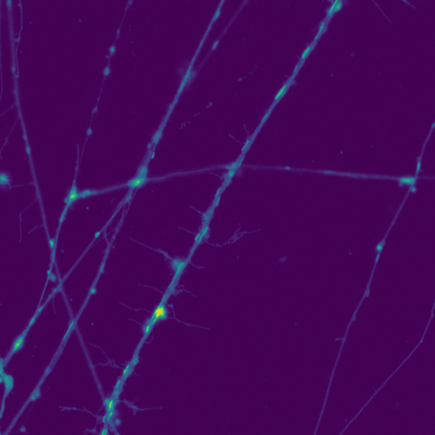

In [12]:
src.train.x[0]

In [13]:
bs = 8
sz_lr = 128
sz_hr = 4*sz_lr
data = get_data(src, bs, sz_lr, sz_hr)

In [17]:
x,y  = data.train_ds[0]

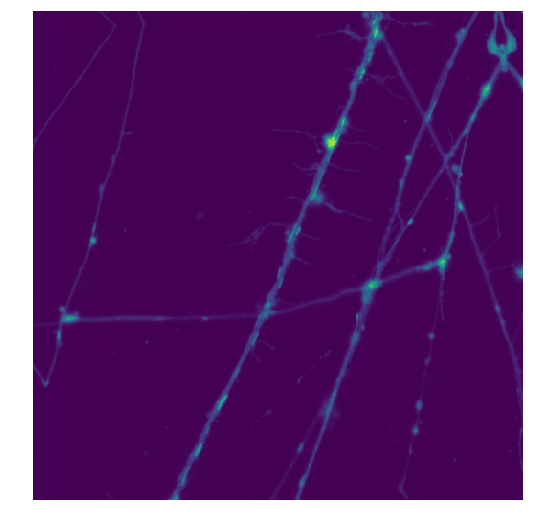

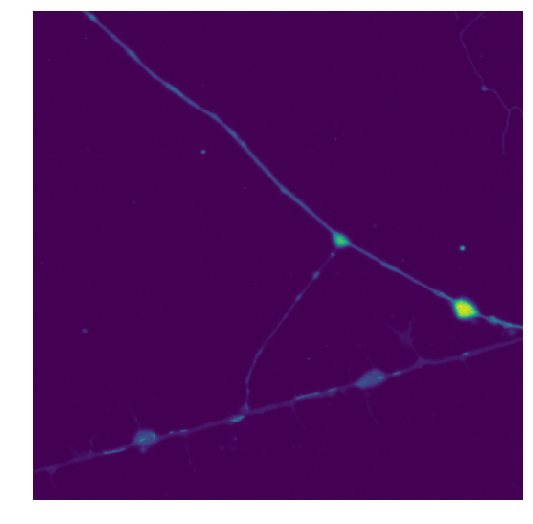

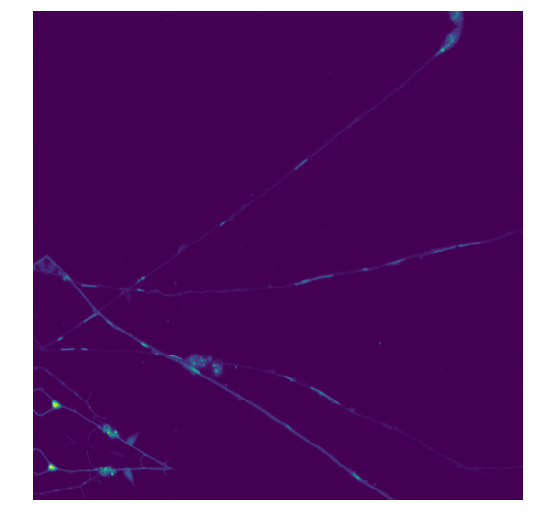

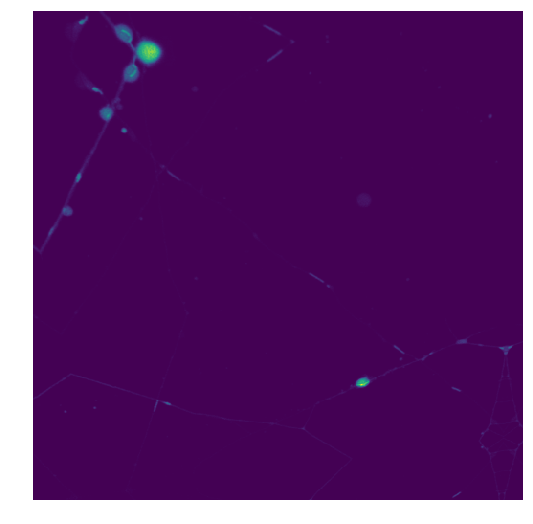

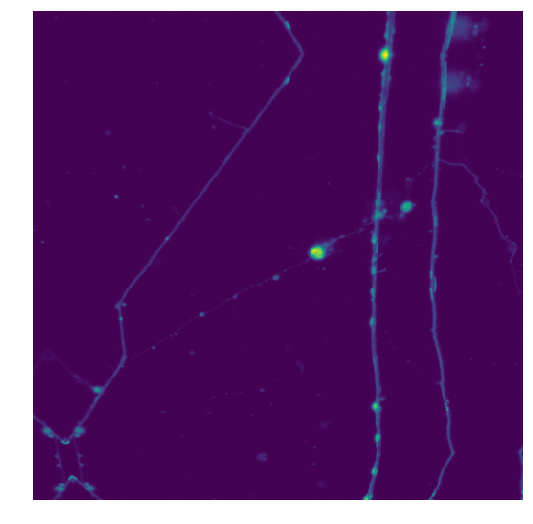

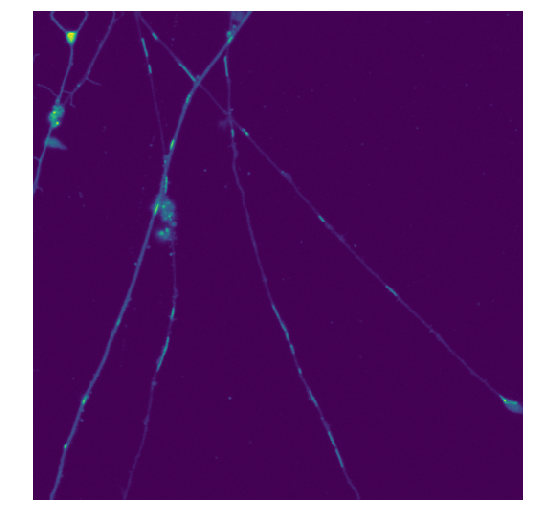

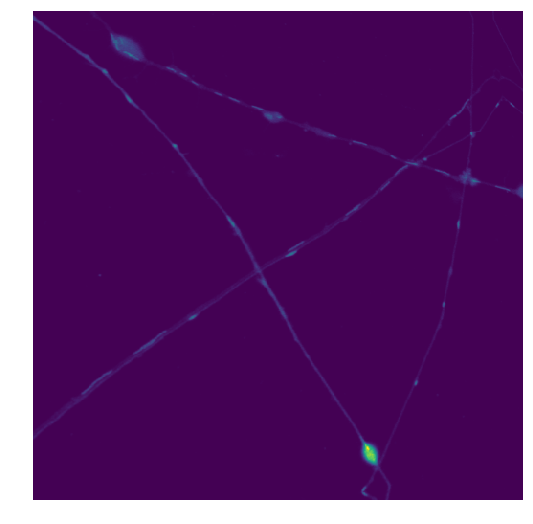

In [21]:
i = 0
for x,y in data.train_ds:
    y.show(figsize=(9,9))
    if i > 5: break
    i+=1

In [22]:
scale=4
model = DBPNLL(num_channels=1, base_filter=8, feat = 256, num_stages=10, scale_factor=scale)
model = nn.DataParallel(model, [0,1,2,3])

In [37]:
def charbonnier_loss(inputs, targets):
    eps = 1e-6;
    d = inputs - targets
    e = torch.sqrt(d**2 + eps)
    return e.mean()

loss = charbonnier_loss
#loss = F.mse_loss
#loss = F.l1_loss


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


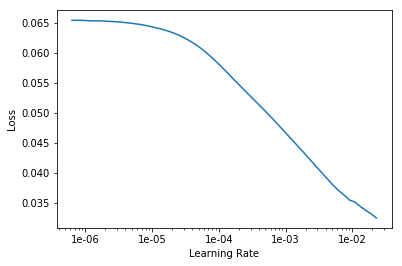

In [38]:
sz_lr = 64
scale,bs = 4,16
sz_hr = sz_lr*scale

learn = build_learner(model, bs, sz_lr, sz_hr, src, loss=loss, model_dir=path_models)
learn.lr_find()
learn.recorder.plot()
#learn.data.train_ds[0][0]

epoch,train_loss,valid_loss,mse_loss,ssim,psnr
1,0.040329,0.003679,0.000015,0.897810,48.122478
2,0.028293,0.005932,0.000046,0.741010,43.347038
3,0.021323,0.005553,0.000038,0.807449,44.208397
4,0.016820,0.002458,0.000006,0.970118,52.490528
5,0.013684,0.001800,0.000003,0.987164,55.597305
6,0.011386,0.002728,0.000007,0.940113,51.543205
7,0.009690,0.002126,0.000004,0.967062,54.214088
8,0.008391,0.001366,0.000001,0.993342,60.154377
9,0.007335,0.001449,0.000001,0.990824,58.933945
10,0.006485,0.001229,0.000001,0.997487,62.182652


save: movies_1.0


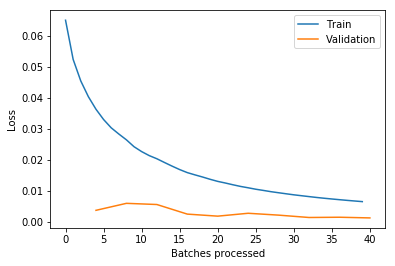

In [39]:
sz_lr = 64
scale,bs = 4,16
sz_hr = sz_lr*scale
epochs, lr = 10, 1e-2
learn = batch_learn(model, bs, sz_lr, sz_hr, lr, epochs, src, 
                    save='movies_1.0', 
                    loss=loss, model_dir=path_models)

In [40]:
learn.show_results(rows=2, imgsize=80)

In [41]:
lr_movies = list((test_path/'lr').iterdir())
hr_movies = list((test_path/'hr').iterdir())

In [44]:
a_movie = lr_movies[0]

In [45]:
a_movie

PosixPath('/scratch/bpho_data/movies/movie_test/lr/MitoTracker Red FM 230x230 2min 03-Airyscan Processing-03.czi')

In [43]:
hr_movies

[PosixPath('/scratch/bpho_data/movies/movie_test/hr/MitoTracker Red FM 920x920 2min 01-Airyscan Processing-07.czi'),
 PosixPath('/scratch/bpho_data/movies/movie_test/hr/MitoTracker Red FM 920x920 10min 02-Airyscan Processing-11.czi'),
 PosixPath('/scratch/bpho_data/movies/movie_test/hr/MitoTracker Red FM 920x920 2min 03-Airyscan Processing-09.czi'),
 PosixPath('/scratch/bpho_data/movies/movie_test/hr/MitoTracker Red FM 920x920 10min 01-Airyscan Processing-10.czi'),
 PosixPath('/scratch/bpho_data/movies/movie_test/hr/MitoTracker Red FM 920x920 10min 03-Airyscan Processing-12.czi'),
 PosixPath('/scratch/bpho_data/movies/movie_test/hr/MitoTracker Red FM 920x920 2min 02-Airyscan Processing-08.czi')]